# Preprocessing the CEA data

In [ ]:
# import python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
import scipy.io as sio
from datetime import datetime
import seaborn as sns
from copy import deepcopy
from sklearn.inspection import permutation_importance

In [ ]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### 1- Load and read data

In [ ]:
path = r"/content/drive/MyDrive/CEA/"
data = pd.read_excel(path + 'TrainingCEA3PatsWide.xlsx')
print(data)
savePath = r"/content/drive/MyDrive/CEA/Results/"


        Id  Id.1  Sex  AgeOK  Smoke  IBS  IBD  Diabetes  FAP  Lynch  ...  \
0        1     1    0     65    2.0    0    0         0    0    0.0  ...   
1        2     2    0     77    0.0    0    0         0    0    0.0  ...   
2        4     4    0     70    0.0    0    0         0    0    0.0  ...   
3        9     9    1     67    2.0    0    0         0    0    0.0  ...   
4       11    11    0     52    NaN    0    0         0    0    0.0  ...   
...    ...   ...  ...    ...    ...  ...  ...       ...  ...    ...  ...   
1540  3163  3163    0     47    0.0    0    0         0    0    0.0  ...   
1541  3166  3166    0     54    0.0    0    0         1    0    0.0  ...   
1542  3170  3170    0     53    1.0    0    0         0    0    0.0  ...   
1543  3171  3171    0     53    1.0    0    0         0    0    0.0  ...   
1544  3172  3172    0     57    0.0    0    0         0    0    0.0  ...   

      ln_CeaOutcome32  ln_CeaOutcome33  ln_CeaOutcome34  ln_CeaOutcome35  \
0          

### 2- Select some of the features

In [ ]:
def select_features(total_measurements, clinical_features, training_data, save_path):
    """


    Parameters
    ----------
    total_measurements : int
        the number of CEA measurements.
    clinical_features : list
        the name of static features that should be selected and labels.
    training_data: dataframe
        the original data
    save_path: string
      the path to the results

    Returns
    -------
    all_features: data frame
      a dataframe with the selected features (dynamic (i.e., CEA measurements), static (i.e., demographic data), and time (i.e., measurements dates)), and labels.

    """

    cea_features = ['CeaOutcome'+str(i+1) for i in range(total_measurements)]
    cea_dates = ['CeaDate'+str(i+1) for i in range(total_measurements)]

    df = training_data[clinical_features] ## include clinical/demographic features (age, sex, ...)
    df1 = training_data[cea_features] ## include CEA measurements
    df2 = training_data[cea_dates] ## include the CEA dates

    all_features = pd.concat([df,df1,df2],axis=1) ## extract the clinical/demographic, CEA, and CEA dates from the dataframe
    all_features = all_features.set_index('Id') ## replace the index with patients' Id
    ### remove the patients who do not have ordered CEA measurements (the order of dates is not correct)
    all_features.drop(all_features.index[192] , inplace = True)
    all_features.drop(all_features.index[220], inplace = True)
    all_features.drop(all_features.index[1114], inplace = True)
    all_features.drop(all_features.index[1422], inplace = True)
    all_features.to_excel(save_path + 'trainingData.xlsx')
    return all_features

### Remove CEA measurements before final operation: These measurements values could be large. We aim to model the changes of CEA after operation



In [ ]:

def select_CeaOutCome_Date(total_measurements, all_features):
  """
    Parameters
    ----------
    total_measurements : int
        the number of CEA measurements.
    all_features : dataframe
        a dataframe contains both clinical/demographic features and CEA measurements and dates.

    Returns
    -------
    CeaMeaDates: dataframe
      a dataframe with the selected features (dynamic (i.e., CEA measurements) and time (i.e., measurements dates)).

  """

##1. select the CeaOutcome and CeaDate from the allFeatures (CeaMDates)
  cea_features = ['CeaOutcome'+str(i+1) for i in range(total_measurements)]
  cea_dates = ['CeaDate'+str(i+1) for i in range(total_measurements)]
  df1 = all_features[cea_features]
  df2 = all_features[cea_dates]
  temp = []
  for i in range(total_measurements):
    temp.append(pd.concat([df1.loc[:,"CeaOutcome" + str(i+1)],df2.loc[:,"CeaDate" + str(i+1)]],axis=1))
    paired_concatenatedList = np.concatenate(temp,axis=1)
    columns_name = []
  for i in range(total_measurements):
    columns_name.append('CeaOutcome' + str(i+1))
    columns_name.append('CeaDate' + str(i+1))

  cl = np.vstack(columns_name)
  cl = cl.T
  CeaMeaDates = pd.DataFrame (paired_concatenatedList,columns = list(cl))
  return CeaMeaDates

def remove_CeaOutCome_AfterFinalOp(total_measurements, all_features):
  """
    Parameters
    ----------
    total_measurements : int
      the number of CEA measurements.
    CeaMeaDates: dataframe
      a dataframe with the selected features (dynamic (i.e., CEA measurements) and time (i.e., measurements dates)).
    all_features : dataframe
      a dataframe contains both clinical/demographic features and CEA measurements and dates.

    Returns
    -------
    dfShifted: dataframe
      a dataframe with the selected features (dynamic (i.e., CEA measurements)
      and time (i.e., measurements dates)) after removing CEAs before final operation
  """
  CeaMeaDates = select_CeaOutCome_Date (total_measurements, all_features)
  ## 2. Extract the final operation from the allFeatures
  ## 3. reserve an array to save the converted operation date (to time) and cea measurement date (to time)
  operationTime = np.zeros(CeaMeaDates.shape[0],)
  CeaTime = np.zeros([CeaMeaDates.shape[0],total_measurements])
  ## reserve an array (index) to save the cea measurements before final operation
  index = np.int16(np.zeros([CeaMeaDates.shape[0],1]))
  ## 4. convert final operation date and cea measurmeent date to time
  ## 5. compare two times for all measurements and patients. If the cea measurement date is less than final operation date
  ## save the index for that patient in index array
  for j in range(CeaMeaDates.shape[0]): ## j is a counter for patient numbers
      if (type(all_features['DateFinalOperation'].iloc[j]) != pd._libs.tslibs.nattype.NaTType):
          operationTime[j] = datetime.timestamp(all_features['DateFinalOperation'].iloc[j])
      for i in range(total_measurements): ## i is the counter for cea measurements
          if (type(CeaMeaDates['CeaDate' + str(i+1)].squeeze().iloc[j]) != pd._libs.tslibs.nattype.NaTType):
              CeaTime[j,i] = datetime.timestamp(CeaMeaDates['CeaDate' + str(i+1)].squeeze().iloc[j])
              if (CeaTime[j,i]<= operationTime[j]):
                  index[j] = index[j] + 1

  ## 6. shift the elements of dataframe based on the index array (i.e, remove the measurements that have
  ##been done before the final operation)
  ## features (cea measurements) of first patient was shifted and saved in df
  df = CeaMeaDates.loc[0].shift(-2*index[0,0]) ## -2 (to remove two elements, ceaDate and ceaOutput)
  i = 1
  while(i<CeaMeaDates.shape[0]):
      shiftedCea = CeaMeaDates.loc[i].shift(-2*index[i,0])
      df=pd.concat([df,shiftedCea],axis=1) ## concatenate a serie to a dataframe to form the whole dataframe
      i = i+1
  dfShifted = df.T ## transpose df after removing measurements

  return dfShifted


### Remove the CEA measurements after recurrence

In [ ]:
def remove_CeaOutcome_AfterRecurrence(total_measurements, dfShifted, all_features):
  """
    Parameters
    ----------
    total_measurements : int
        the number of CEA measurements.
    dfShifted: dataframe
      a dataframe with the selected features (dynamic (i.e., CEA measurements)
      and time (i.e., measurements dates)) after removing CEAs before final operation
    all_features : dataframe
        a dataframe contains both clinical/demographic features and CEA measurements and dates.

    Returns
    -------
    dfShifted: dataframe
      a dataframe with CEA measurements removed after recurrence

  """
  recurrence = all_features.index[all_features['Recurrence'] == True].to_numpy()
  recurrenceDate = all_features['DateRecurrence'][recurrence]
  cutoffIndex_recurrence = np.zeros([recurrence.shape[0],]) ## the cut-off point when the CEA measurements occur after recurrence
  id_ = all_features.index
  dfShifted = dfShifted.set_index(id_)
  recurrenceTime = np.zeros(recurrenceDate.shape[0],) ## an array to save the converted recurrence date to time
  CeaTime = np.zeros([recurrence.shape[0],total_measurements])
  k = 0
  for j in range(recurrence.shape[0]): ## j is a counter for patient numbers
      if (type(all_features['DateRecurrence'].loc[recurrence[j]]) != pd._libs.tslibs.nattype.NaTType):
          recurrenceTime[j] = datetime.timestamp(all_features['DateRecurrence'].loc[recurrence[j]])
      for i in range(total_measurements): ## i is the counter for cea measurements
          if (type(dfShifted['CeaDate' + str(i+1)].squeeze().loc[recurrence[j]]) != pd._libs.tslibs.nattype.NaTType):
              CeaTime[j,i] = datetime.timestamp(dfShifted['CeaDate' + str(i+1)].squeeze().loc[recurrence[j]])
              if (CeaTime[j,i]> recurrenceTime[j]):
                  cutoffIndex_recurrence[j] = i
                  dfShifted.loc[recurrence[j],'CeaDate' + str(i+1)] = pd.NaT
                  dfShifted.loc[recurrence[j],'CeaOutcome' + str(i+1)] = np.NaN

  return dfShifted


### Preprocess features

In [ ]:
def preprocessing(features, featuresType, combinedFeatures):
    """
    inputs:
          features: a numpy array (initialized with demographic (or equivalently static features), then it will be filled with dynamic features (i.e., CEA measurements))
          featuresType: List (initialized with the demographic (or equivalently static features), then it will be filled with dynamic features types)
          combinedFeatures: List ()
    outputs:
          preprocessedFeatures: List
    Description:
          This function preprocess the data:
          1- imput the missing values: if the feature type is binary or categorical, impute them based on the most frequent strategy
          if not, impute using the median of values in each feature vector
          2- if binary value is equak to zero make it -1, if the feature type is categotical apply one-hot-encoder
          3- append the features to the preprocessedFeatures list
    """

    preprocessedFeatures = []

    for f, feature in enumerate(combinedFeatures):

        #feature = staticFeatures[f]
        if featuresType[f] == 'bin':
            imputer = SimpleImputer(strategy='most_frequent')
            features[:,f:f+1] = imputer.fit_transform(features[:,f:f+1])
            features[features[:,f]==0,f] = -1
            preprocessedFeatures.append(features[:,f:f+1])
        elif featuresType[f] == 'con':
            imputer = SimpleImputer(strategy='median')
            features[:,f:f+1] = imputer.fit_transform(features[:,f:f+1])
            preprocessedFeatures.append(features[:,f:f+1])
        elif featuresType[f] == 'cat':
            imputer = SimpleImputer(strategy='most_frequent')
            features[:,f:f+1] = imputer.fit_transform(features[:,f:f+1])
            ohe = OneHotEncoder(sparse = False) ## return an array
            temp = ohe.fit_transform(features[:,f:f+1])
            preprocessedFeatures.append(temp)
            # features = np.concatenate([features[:,0:f], temp, features[:,f+1:]], axis=1)

    return preprocessedFeatures


### define the classifier and fit it on data

In [ ]:
def classifier(X, y, m, s):
    """
      Inputs:
        X: numpy array (preprocessed data)
        y: numpy array (labels)
        m: list (to keep the mean scores)
        s: list (to keep std scores)
      outputs:
        m , s
      Description:
        this function apply a classifier on data and evaluate the performance
        model selection is 10-fold cross-validation
    """
    ## train the classifier and evalute the result
    clf = RandomForestClassifier()
    ## feature importance
    clf.fit(X,y)
    feature_names = [f"feature {i}" for i in range(X.shape[1])]
    #base_estimator = RandomForestClassifier(class_weight='balanced')
    #clf = BaggingClassifier(base_estimator=base_estimator)

    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=feature_names)

    plt.figure(figsize= (16,16))
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    plt.savefig(savePath + 'feature_importance_MDI' + '.png')

    result = permutation_importance(
    clf, X, y, n_repeats=10, random_state=42, n_jobs=2)
    forest_importances = pd.Series(result.importances_mean, index=feature_names)
    plt.figure(figsize=(16,16))
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
    ax.set_title("Feature importances using permutation on full model")
    ax.set_ylabel("Mean accuracy decrease")
    fig.tight_layout()
    plt.show()
    plt.savefig(savePath + 'feature_importance_permutation' + '.png')

    ## computing the roc_auc
    scores = cross_val_score(clf, X, y, cv=10, scoring = "roc_auc")
    print('Mean:%.2f, std:%.2f' %(scores.mean(), scores.std())) ## compute the mean and the std of roc_auc
    mean, std = scores.mean(), scores.std()
    m.append(np.round(mean,2))
    s.append(np.round(std, 2))
    sio.savemat(savePath + 'mean_val_scores_' + str(numCEA) + '.mat',{'mean':m, 'std':s})
    return m, s

### Plot the mean of scores

In [ ]:
def plot(m, savePath):
    """

    Parameters
    ----------
    m : an array with the mean of roc_auc


    Returns
    -------
    None.

    """
    m = np.stack(m)
    plt.figure()
    plt.xlim([0, 14]) ## the results on 13 first CEA measurements (added one by one) + the results of classifier on staticFeatures
    plt.plot(m, linestyle='--', marker='o', color='b')
    plt.xticks(ticks = range(14))
    plt.xlabel('CEA measurements')
    plt.ylabel('roc_auc') ## mean of roc_auc
    plt.savefig(savePath + 'Accuracy_based_13ceaMeasurements' + '.png')


### Count the number of NaN values

In [ ]:
def count_NaNs(measurements_num, all_features):
    """
    Parameters
    ----------
    measurements_num : int
        the number of CEA measurements included in the analysis.
    all_features:
        a combination of static (clinical/demographic) data and dynamic (CEA measurements)
    Returns
    -------
    None.

    Description:
       this function checks how many missing/non-missing values exist for each patient and generally all patients

    """
    ceaMeasurements = ['CeaOutcome' + str(i+1) for i in range(measurements_num)]
    ceaDataframe = all_features[ceaMeasurements] ## select the columns with cea measurements
    numMissing = ceaDataframe.isnull().sum(axis=0) ## count the number of missing values for each patient
    percentMissing = (numMissing.to_numpy())/all_features.shape[0] ## convert the serie data type to a numpy array
    percentnumNonMiss = (all_features.shape[0] - (numMissing.to_numpy()))/all_features.shape[0]
    # print('percentMissing:%d, Max:%d, Median:%d, Mean:%d' %(np.min(numMissing),np.max(numMissing),np.median(numMissing),np.mean(numMissing)))
    return percentMissing, percentnumNonMiss

### Plot the percentage of non-missing values

In [ ]:
# plot the percentage of available measurments for all patients
def plot_NaNs(percentnumNonMiss,savePath):
    plt.figure(figsize= (16,16))
    plt.plot(percentnumNonMiss, linestyle='--', marker='o', color='b')
    plt.xticks(ticks = range(40)) ## total number of CEA measurements is 40
    plt.xlabel('CEA measurements')
    plt.ylabel('Percentage of measurements')
    #plt.show()
    plt.savefig(savePath + 'Percentage of NaN_Measurements' + '.png')


### 1. Define the variables and set the values
### 2. Call the select_featuers function (to select only needed features from the original data)
### 3. Call the functions to count missing and non-missing values and plot them

      Sex  AgeOK  Smoke  IBS  IBD  Diabetes  FAP  Lynch  Cardiaal  Organ  ...  \
Id                                                                        ...   
1       0     65    2.0    0    0         0    0    0.0         0      0  ...   
2       0     77    0.0    0    0         0    0    0.0         0      0  ...   
4       0     70    0.0    0    0         0    0    0.0         0      1  ...   
9       1     67    2.0    0    0         0    0    0.0         1      0  ...   
11      0     52    NaN    0    0         0    0    0.0         0      0  ...   
...   ...    ...    ...  ...  ...       ...  ...    ...       ...    ...  ...   
3163    0     47    0.0    0    0         0    0    0.0         0      0  ...   
3166    0     54    0.0    0    0         1    0    0.0         0      1  ...   
3170    0     53    1.0    0    0         0    0    0.0         0      0  ...   
3171    0     53    1.0    0    0         0    0    0.0         0      1  ...   
3172    0     57    0.0    0

24

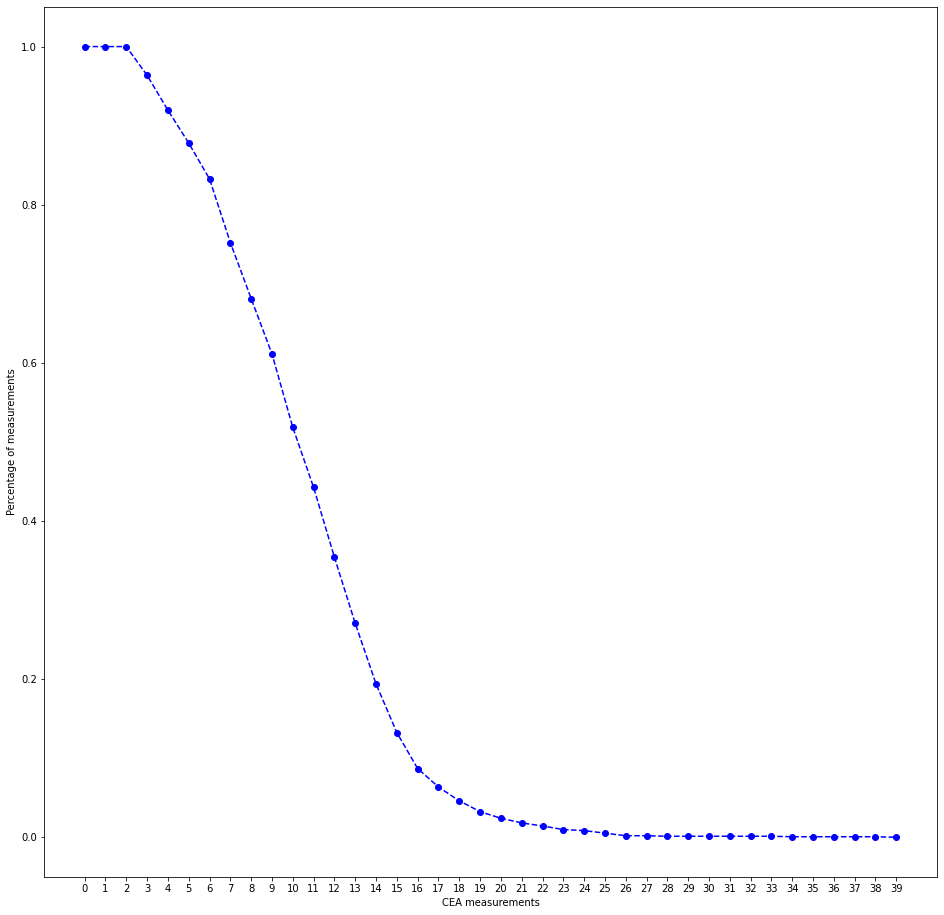

In [ ]:
totalMeasurements = 40 ## total number of CEA measurements
clinicalFeatures_labels = ['Id','Sex', 'AgeOK', 'Smoke','IBS','IBD','Diabetes','FAP', ## all needed clinical (static features, dates, Id of patients, and labels)
                  'Lynch','Cardiaal','Organ', 'cTNM', 'Neoadj_Rect', 'ycTNM', 'SynchMeta', 'LocationMeta', 'PalliativeSetting',
                  'p(y)TNM','Tumor', 'StadiumCancer', 'ResectionMargeFree', 'LymfInvasion', 'AngioInvasion',
                   'AdjuvChemo', 'AdjuvRadio', 'Recurrence','DateRecurrence','Survival','DateFinalOperation']
numCEA = 13 ## 13 first measurements have less NaNs (majority of patients have 13 measurements).
staticFeatures = ['Sex', 'AgeOK', 'Smoke','IBS','IBD','Diabetes','FAP', ## all needed clinical (static features, dates, Id of patients, and labels)
                  'Lynch','Cardiaal','Organ', 'cTNM', 'Neoadj_Rect', 'ycTNM', 'SynchMeta', 'LocationMeta', 'PalliativeSetting',
                  'p(y)TNM','Tumor', 'StadiumCancer', 'ResectionMargeFree', 'LymfInvasion', 'AngioInvasion',
                   'AdjuvChemo', 'AdjuvRadio'] ## static features to be included in the analysis
staticFeaturesType = ['bin','con','cat','bin','bin','bin','bin','bin', ## type of static features (needed for preprocessing)
                          'bin','bin', 'cat', 'cat', 'cat', 'bin','bin', 'bin','cat','cat','cat','bin','bin','bin','bin','bin']
dynamicFeatures = ['CeaOutcome' + str(i+1) for i in range(numCEA)] ## extract dynamic features (numCEA showes how many dynamic features are selected)
dynamicFeaturesType = ['con' for i in range(numCEA)] ## the CEA measurements are continuos
targets = ['Recurrence'] ## if the patient has recurrence 1, otherwise 0
allFeatures = select_features(totalMeasurements, clinicalFeatures_labels, data, savePath) ## all features (included dynamic and static features,target, dates,...)
print(allFeatures)
## remove the CEA measurements before the final operation
removedFO = remove_CeaOutCome_AfterFinalOp(totalMeasurements, allFeatures)
## remove CEAs after the recurrence
removedRecurrence = remove_CeaOutcome_AfterRecurrence(totalMeasurements, removedFO, allFeatures)
removedRecurrence.columns = ['CeaOutcome1', 'CeaDate1','CeaOutcome2', 'CeaDate2','CeaOutcome3', 'CeaDate3','CeaOutcome4', 'CeaDate4','CeaOutcome5', 'CeaDate5','CeaOutcome6', 'CeaDate6',
                     'CeaOutcome7', 'CeaDate7','CeaOutcome8', 'CeaDate8','CeaOutcome9', 'CeaDate9','CeaOutcome10', 'CeaDate10','CeaOutcome11', 'CeaDate11','CeaOutcome12', 'CeaDate12',
                     'CeaOutcome13', 'CeaDate13','CeaOutcome14', 'CeaDate14','CeaOutcome15', 'CeaDate15','CeaOutcome16', 'CeaDate16','CeaOutcome17', 'CeaDate17','CeaOutcome18', 'CeaDate18',
                     'CeaOutcome19', 'CeaDate19','CeaOutcome20', 'CeaDate20','CeaOutcome21', 'CeaDate21','CeaOutcome22', 'CeaDate22','CeaOutcome23', 'CeaDate23','CeaOutcome24', 'CeaDate24',
                     'CeaOutcome25', 'CeaDate25','CeaOutcome26', 'CeaDate26','CeaOutcome27', 'CeaDate27','CeaOutcome28', 'CeaDate28','CeaOutcome29', 'CeaDate29','CeaOutcome30', 'CeaDate30',
                     'CeaOutcome31', 'CeaDate31','CeaOutcome32', 'CeaDate32','CeaOutcome33', 'CeaDate33','CeaOutcome34', 'CeaDate34','CeaOutcome35', 'CeaDate35','CeaOutcome36', 'CeaDate36',
                     'CeaOutcome37', 'CeaDate37','CeaOutcome38', 'CeaDate38','CeaOutcome39', 'CeaDate39','CeaOutcome40', 'CeaDate40']
removedRecurrence.to_excel(savePath + 'trainingData_afterRemovingRecurrence.xlsx')
finalDF = pd.concat([allFeatures[clinicalFeatures_labels[1:]],removedRecurrence],axis=1)
print(finalDF)
len(staticFeatures)
percentMissing, percentnumNonMiss =count_NaNs(totalMeasurements, finalDF)
plot_NaNs(percentnumNonMiss,savePath)
len(staticFeatures)

## Set the values of parameteres:
### 1. select the needed features and labels from the original data
### 2. extract static and dynamic features
### 3. preprocesss features
### 4. employ a classifier to see the effect of adding static features and adding dynamic features one by one on the recurrece prediction/detection and evaluate the results
### 5. plot the resulting scores


['Sex', 'AgeOK', 'Smoke', 'IBS', 'IBD', 'Diabetes', 'FAP', 'Lynch', 'Cardiaal', 'Organ', 'cTNM', 'Neoadj_Rect', 'ycTNM', 'SynchMeta', 'LocationMeta', 'PalliativeSetting', 'p(y)TNM', 'Tumor', 'StadiumCancer', 'ResectionMargeFree', 'LymfInvasion', 'AngioInvasion', 'AdjuvChemo', 'AdjuvRadio']


<Figure size 1152x1152 with 0 Axes>

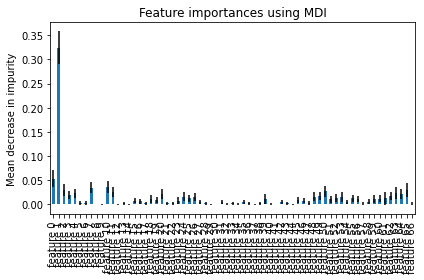

<Figure size 1152x1152 with 0 Axes>

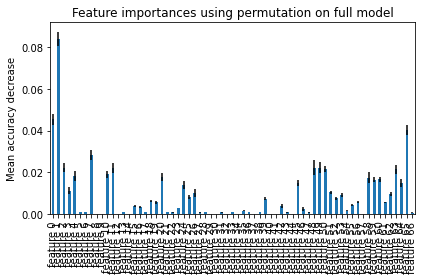

Mean:0.63, std:0.06
[[-1. 65.  0. ... -1. -1. -1.]
 [-1. 77.  1. ... -1. -1. -1.]
 [-1. 70.  1. ... -1. -1. -1.]
 ...
 [-1. 53.  0. ... -1. -1. -1.]
 [-1. 53.  0. ... -1. -1. -1.]
 [-1. 57.  1. ...  1. -1. -1.]]


<Figure size 432x288 with 0 Axes>

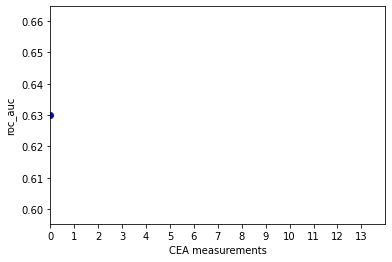

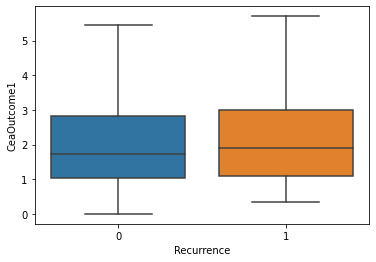

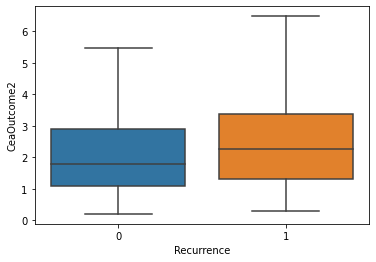

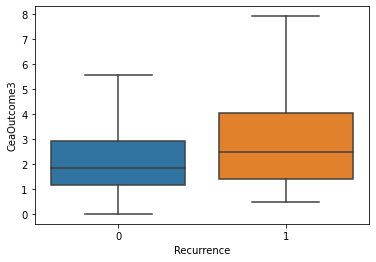

In [ ]:
combined_StaticDynamic = []
combined_StaticDynamicType = []
combined_StaticDynamic = deepcopy(staticFeatures) ## staticFeatures are copied in a new list that will contain both dynamic and static features
print (combined_StaticDynamic)
combined_StaticDynamicType = deepcopy(staticFeaturesType) ## staticFeatures types are copied in a new list that will contain both dynamic and static features types.
m = []
s = []
numCEA = 0
for i in range(numCEA+1):
    ### the dynamic data (cea measurements are added to the static data one by one)
    featureMatrix = finalDF[combined_StaticDynamic].to_numpy() ## convert dataframe to a numpy array
    preprocessedFeatures = preprocessing(featureMatrix, combined_StaticDynamicType, combined_StaticDynamic) ## preprocess data
    X = np.concatenate(preprocessedFeatures,axis=1) ## preprocessed features are concatenated to form the X array (feature matrix)
    y = finalDF[targets].to_numpy().squeeze() ## convert targets to a numpy array
    m, s = classifier(X, y, m, s) ## employ classifer on the preprocessed features (in the first run i.e., i=0, only staticFeatures are fed to the classifer)
    if (i == numCEA):
        break
    else:
        combined_StaticDynamic.append(dynamicFeatures[i]) ## until i is equal to numCEA, add CEA measurements one by one to the combined_StaticDynamic and repeat the procedure
        combined_StaticDynamicType.append(dynamicFeaturesType[i]) ## until i is equal to numCEA, add the type of CEA measurements one by one to the combined_StaticDynamicType and repeat the procedure
print (X)
plot(m, savePath)
for i in range(3):
    fig, ax = plt.subplots()
    sns.boxplot(x='Recurrence',y='CeaOutcome' + str(i+1),data=finalDF, showfliers = False)
    plt.savefig(savePath + 'BoxPlot_Recurrence_vs_noneRecurrence' + 'CeaOutcome' + str(i+1)+'.png')

#print(featureMatrix.shape[1])
#print(X.shape[1])
#print(len(preprocessedFeatures))
#print(preprocessedFeatures)
#print(combined_StaticDynamic)
#print(len(combined_StaticDynamicType))
#%%
